<a href="https://colab.research.google.com/github/marcosmedvescig/thesis_survival_models_for_predicting_churn/blob/master/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA (Exploratory Data Analysis)



## Install libraries

Note: After installing the libraries for the first time restart the runtime (CTRL + M) for the new versions of the library to be loaded.

In [ ]:
## Install libraries
!pip install pysurvival=='0.1.2'
!pip install scikit-survival=='0.13.1'
!pip install osqp=='0.5.0'

     |████████████████████████████████| 4.8MB 2.7MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp36-cp36m-linux_x86_64.whl size=3774928 sha256=83997e9817aff54d1bc9883299d28fce9d73c3e95a1084a1e15e2c89ad34e1b8
  Stored in directory: /root/.cache/pip/wheels/6c/23/e8/6feb0c4432219666bdd5d33828d7d9f429c4726f34c6fa8061
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=d200b209872eecffd40c19ec22c02064bb7f2503661b85880be93988be6aafc3
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built pysurvival progressbar
     |████████████████████████████████| 1.8MB 346kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 153kB 4.2MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.13.1-cp36-cp36m-linux_x86_64.whl size=4119301 sha256=d5adf2

## Load Data

In [ ]:
import pandas as pd
import numpy as np
import os

# Open dataset
raw_data = pd.read_csv('https://github.com/marcosmedvescig/thesis_survival_models_for_predicting_churn/raw/master/churn_data_anonymized_20200718.csv')
raw_data.rename(columns={'survival_days': 'time', 'status': 'event'},inplace=True)

raw_data.head()

,store_id,time,event,country,max_segment,creation_platform,products_created,admin_visits,source,seller_probability,tx,gmv_usd
0,1842269723731683560,261,1,A,B,A,-0.080154,-0.161978,I,1.014303,-0.042809,-0.071061
1,4773050910207726165,107,1,A,C,A,0.012447,0.566017,I,-0.214408,-0.076793,-0.092084
2,4171477716070775996,102,0,C,A,A,-0.075205,2.295003,A,-0.467481,0.602888,0.209250
3,-558102186785033374,101,1,C,C,A,-0.078033,-0.935472,A,-0.574383,-0.110777,-0.106463
4,-2987486431769169084,444,0,A,B,A,-0.063189,0.611516,I,1.614260,-0.099449,-0.103126


## Data overview


In [ ]:
# Number of observations
print('Total number of observations: {0}'.format(len(raw_data)))
print('Total number of churns: {0}'.format(len(raw_data[raw_data['event'] == 1])))

Total number of observations: 3484
Total number of churns: 2048


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


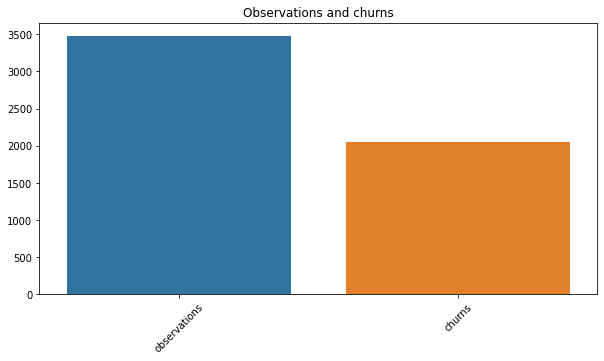

In [ ]:
# feature_importance.plot.bar(x='feature', y='pct_importance', rot=0);
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.figure(figsize=(10,5))

ax = sns.barplot(x=['observations','churns'], 
                 y=[len(raw_data),len(raw_data[raw_data['event'] == 1])])
ax.set_title('Observations and churns')

ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

## Main Statistics

In [ ]:
data_statistics = raw_data.describe()
data_statistics

,store_id,time,event,products_created,admin_visits,seller_probability,tx,gmv_usd
count,3.484000e+03,3484.000000,3484.000000,3484.000000,3484.000000,3484.000000,3484.000000,3484.000000
mean,-2.291610e+17,222.832090,0.587830,-0.000343,-0.008566,-0.004779,-0.017090,-0.001476
std,5.355273e+18,178.699726,0.492296,0.736465,1.016209,1.000617,0.476106,0.809769
min,-9.216022e+18,-295.000000,0.000000,-0.111256,-1.253969,-0.784695,-0.110777,-0.106463
25%,-4.900232e+18,80.000000,0.000000,-0.102773,-0.753473,-0.692192,-0.110777,-0.106463
50%,-2.419155e+17,166.000000,1.000000,-0.087222,-0.252977,-0.585727,-0.110777,-0.106463
75%,4.422534e+18,333.000000,1.000000,-0.049051,0.520517,1.020630,-0.088121,-0.089639
max,9.217836e+18,733.000000,1.000000,33.032587,16.536393,2.005650,7.614935,27.730576


### Negative time

In [ ]:
# Remove observations with negative time.

print('Number of observations with negative time: {0}'.format(len(raw_data[raw_data['time']<0])))
raw_data = raw_data[raw_data['time']>=0]

Number of observations with negative time: 8


### Outliers

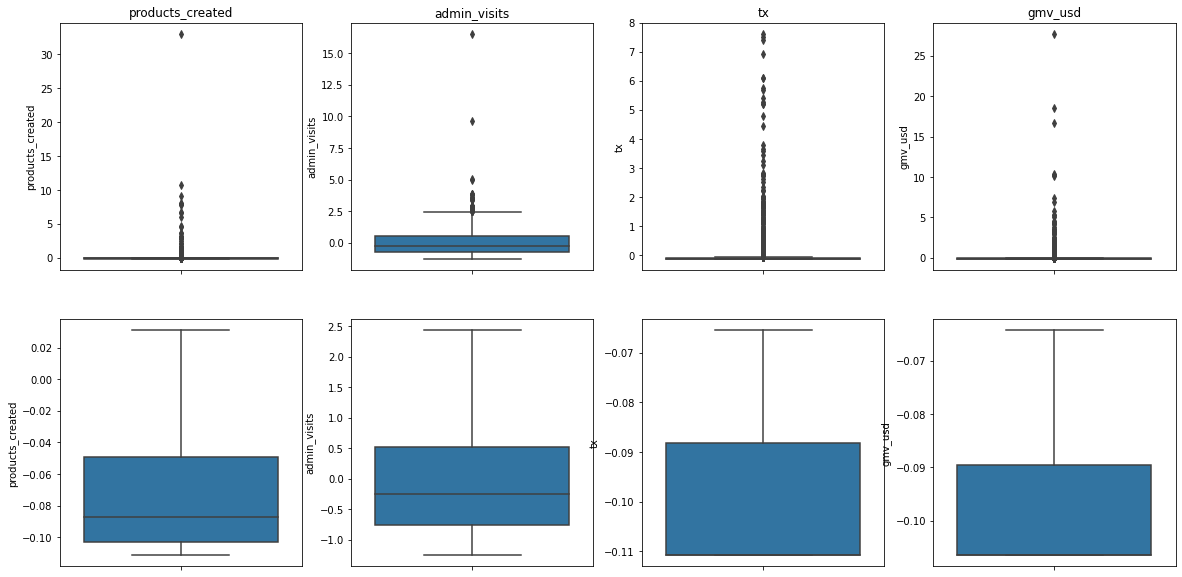

In [ ]:
# Plot outliers

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.subplot(2,4,1)
plt.title('products_created')
sns.boxplot(y=raw_data['products_created'])

plt.subplot(2,4,2)
plt.title('admin_visits')
sns.boxplot(y=raw_data['admin_visits'])

plt.subplot(2,4,3)
plt.title('tx')
sns.boxplot(y=raw_data['tx'])

plt.subplot(2,4,4)
plt.title('gmv_usd')
sns.boxplot(y=raw_data['gmv_usd'])

plt.subplot(2,4,5)
sns.boxplot(y=raw_data['products_created'],showfliers=False)

plt.subplot(2,4,6)
sns.boxplot(y=raw_data['admin_visits'],showfliers=False)

plt.subplot(2,4,7)
sns.boxplot(y=raw_data['tx'],showfliers=False)

plt.subplot(2,4,8)
sns.boxplot(y=raw_data['gmv_usd'],showfliers=False);

In [ ]:
print('Number of observations before removing outliers: {}'.format(len(raw_data)))

import pandas as pd

for feature in ['products_created','admin_visits','tx','gmv_usd']:
  print('Number of observations with outliers: {} for the feature {}'.format(len(raw_data),feature))

  # Remove data with the quantiles method
  q1 = data_statistics[feature]['25%']
  q3 = data_statistics[feature]['75%']
  iqr = q3 - q1

  raw_data = raw_data[~((raw_data[feature] < (q1 - 1.5 * iqr)) | (raw_data[feature] > (q3 + 1.5 * iqr))) ]
  print('Number of observations after removing outliers with quantiles method: {} for the feature {}'.format(len(raw_data),feature))

  # Remove data with the std method
  raw_data = raw_data[raw_data[feature] <= (data_statistics[feature]['mean'] + 3 * data_statistics[feature]['std'])]
  print('Number of observations after removing outliers with std method: {} for the feature {}'.format(len(raw_data),feature))

print('Number of observations after removing outliers: {}'.format(len(raw_data)))

Number of observations before removing outliers: 3476
Number of observations with outliers: 3476 for the feature products_created
Number of observations after removing outliers with quantiles method: 3064 for the feature products_created
Number of observations after removing outliers with std method: 3064 for the feature products_created
Number of observations with outliers: 3064 for the feature admin_visits
Number of observations after removing outliers with quantiles method: 3031 for the feature admin_visits
Number of observations after removing outliers with std method: 3031 for the feature admin_visits
Number of observations with outliers: 3031 for the feature tx
Number of observations after removing outliers with quantiles method: 2572 for the feature tx
Number of observations after removing outliers with std method: 2572 for the feature tx
Number of observations with outliers: 2572 for the feature gmv_usd
Number of observations after removing outliers with quantiles method: 2501 

In [ ]:
raw_data.describe()

,store_id,time,event,products_created,admin_visits,seller_probability,tx,gmv_usd
count,2.501000e+03,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000
mean,-2.782495e+17,196.481407,0.648141,-0.084003,-0.345286,-0.347213,-0.105523,-0.103611
std,5.380735e+18,166.484018,0.477646,0.029286,0.694060,0.707643,0.010534,0.006875
min,-9.212994e+18,0.000000,0.000000,-0.111256,-1.253969,-0.784695,-0.110777,-0.106463
25%,-4.979862e+18,65.000000,0.000000,-0.105601,-0.889972,-0.710518,-0.110777,-0.106463
50%,-3.264495e+17,137.000000,1.000000,-0.094291,-0.480475,-0.635033,-0.110777,-0.106463
75%,4.498318e+18,281.000000,1.000000,-0.071671,0.020021,-0.487553,-0.099449,-0.106218
max,9.217836e+18,732.000000,1.000000,0.030825,2.431502,1.960708,-0.065465,-0.065042


### Missings

In [ ]:
# Remove missings.
print('Number of observations with missings: {0}'.format(len(raw_data)))
raw_data.dropna(inplace=True)
print('Number of observations without missings: {0}'.format(len(raw_data)))

Number of observations with missings: 2501
Number of observations without missings: 2501


### Duplicates

In [ ]:
# Check for duplicated values

print('Number of observations with duplicates: {0}'.format(len(raw_data)))
raw_data = raw_data.drop_duplicates(subset=['store_id'],keep='first').reset_index(drop=True)
print('Number of observations without duplicates: {0}'.format(len(raw_data)))

Number of observations with duplicates: 2501
Number of observations without duplicates: 2501


### Correlation

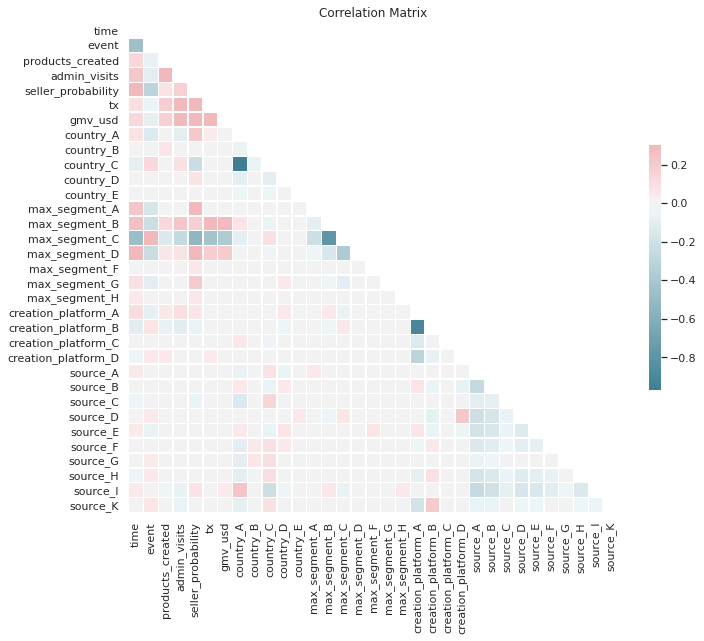

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = pd.get_dummies(raw_data.drop(['store_id'], axis=1)).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix');

In [ ]:
# Plot the highest correlations

c = corr.abs()
s = c.unstack()
so = s.sort_values(kind="quicksort",ascending=False)

so[33:50]

country_A            country_C              0.969270
country_C            country_A              0.969270
creation_platform_A  creation_platform_B    0.914019
creation_platform_B  creation_platform_A    0.914019
gmv_usd              tx                     0.801643
tx                   gmv_usd                0.801643
max_segment_B        max_segment_C          0.791613
max_segment_C        max_segment_B          0.791613
seller_probability   max_segment_C          0.536002
max_segment_C        seller_probability     0.536002
time                 max_segment_C          0.483283
max_segment_C        time                   0.483283
admin_visits         products_created       0.454905
products_created     admin_visits           0.454905
time                 event                  0.453888
event                time                   0.453888
time                 seller_probability     0.440555
dtype: float64

#### tx and gmv_usd

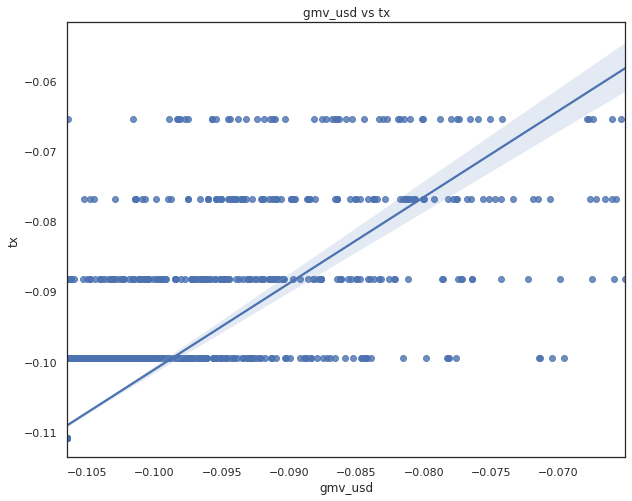

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.regplot(x='gmv_usd', y='tx', data=raw_data)

plt.title('gmv_usd vs tx');

In [ ]:
import statsmodels.api as sm

# Note the difference in argument order
model = sm.OLS(raw_data['tx'], raw_data['gmv_usd']).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     tx   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          6.715e+05
Date:                Mon, 10 Aug 2020   Prob (F-statistic):                        0.00
Time:                        20:54:04   Log-Likelihood:                          9062.1
No. Observations:                2501   AIC:                                 -1.812e+04
Df Residuals:                    2500   BIC:                                 -1.812e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
gmv_usd        1.0194      0.001    819.441      0.000       1.017       1.022
==============================================================================
Omnibus:                     1236.333   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8884.145
Skew:                           2.238   Prob(JB):                         0.00
Kurtosis:                      11.076   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### country_A and country_C

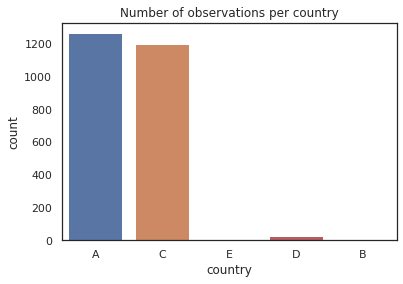

In [ ]:
# Observations per country
import seaborn as sns

ax = sns.countplot(x='country', data=raw_data)
ax.set_title('Number of observations per country');

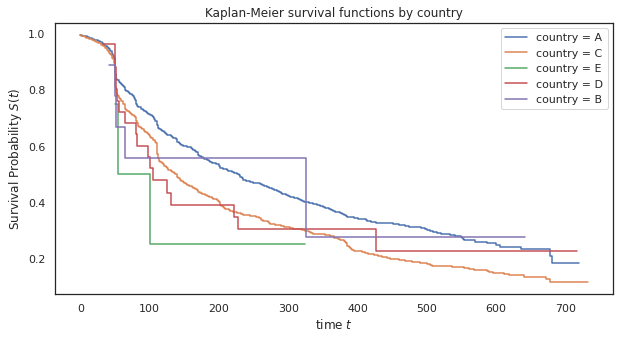

In [ ]:
# Kaplan-Meier - country_A vs country_C

import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

plt.figure(figsize=(10,5))

raw_data['event'] = raw_data['event'].astype(bool)

for country in ['A','C','E','D','B']:
    mask_segment = raw_data['country'] == country
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        raw_data['event'][mask_segment],
        raw_data['time'][mask_segment])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="country = %s" % country)

plt.ylabel("Survival Probability $S(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.title('Kaplan-Meier survival functions by country');

#### creation_platform_A and creation_platform_B

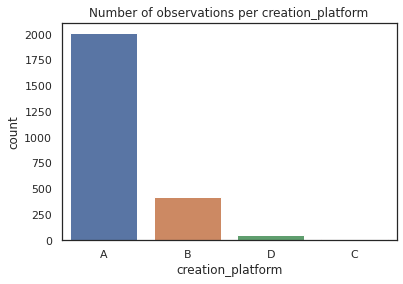

In [ ]:
import seaborn as sns

ax = sns.countplot(x='creation_platform', data=raw_data)
ax.set_title('Number of observations per creation_platform');

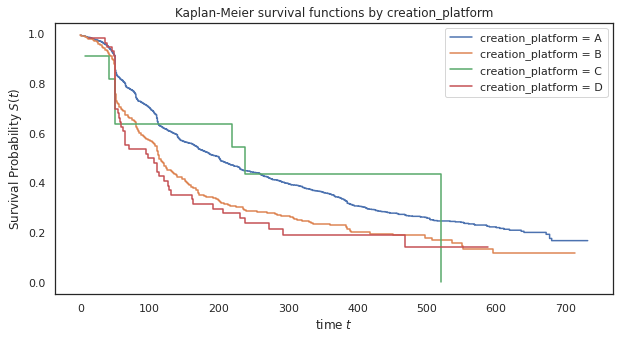

In [ ]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

plt.figure(figsize=(10,5))

raw_data['event'] = raw_data['event'].astype(bool)

for creation_platform in ['A','B','C','D']:
    mask_segment = raw_data['creation_platform'] == creation_platform
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        raw_data['event'][mask_segment],
        raw_data['time'][mask_segment])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="creation_platform = %s" % creation_platform)

plt.ylabel("Survival Probability $S(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.title('Kaplan-Meier survival functions by creation_platform');

#### max_segment_B and max_segment_C


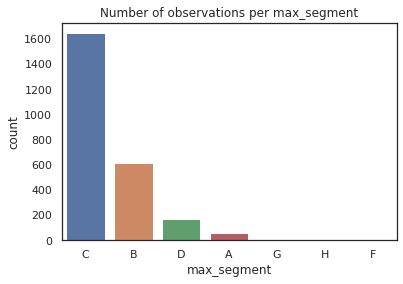

In [ ]:
import seaborn as sns

ax = sns.countplot(x='max_segment', data=raw_data)
ax.set_title('Number of observations per max_segment');

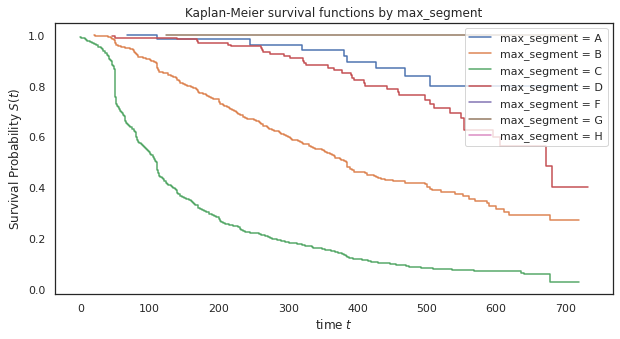

In [ ]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

plt.figure(figsize=(10,5))

raw_data['event'] = raw_data['event'].astype(bool)

for creation_platform in ['A','B','C','D','F','G','H']:
    mask_segment = raw_data['max_segment'] == creation_platform
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        raw_data['event'][mask_segment],
        raw_data['time'][mask_segment])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="max_segment = %s" % creation_platform)

plt.ylabel("Survival Probability $S(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.title('Kaplan-Meier survival functions by max_segment');